In [1]:
import xarray as xr
import rasterio as rio
import rioxarray
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import pandas as pd
import geopandas as gpd
from rasterio.features import geometry_mask
import numpy as np


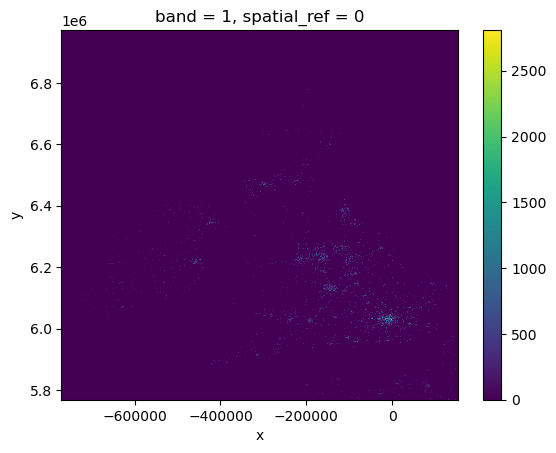

In [29]:
def load_raster(path):
    with rio.open(path) as file:
        raster_data = file.read()
        transform = file.transform
        crs = file.crs
        raster_data = xr.DataArray(raster_data).squeeze()
        # Add crs and transform as metadata
        raster_data.attrs['transform'] = transform
        raster_data.attrs['crs'] = crs

    return raster_data


path_electricity = "data/annual-heat-electricity-demand-twh.csv"
path_populations = "build/population-europe.tif"
path_spatial_units_national = "data/units_national.geojson"

spatial_units_national = gpd.read_file(path_spatial_units_national).set_index("id")

# populations = load_raster(path_populations)
populations = rioxarray.open_rasterio(path_populations).squeeze()  #, chunks={'x': 100, 'y': 100}
populations.plot()


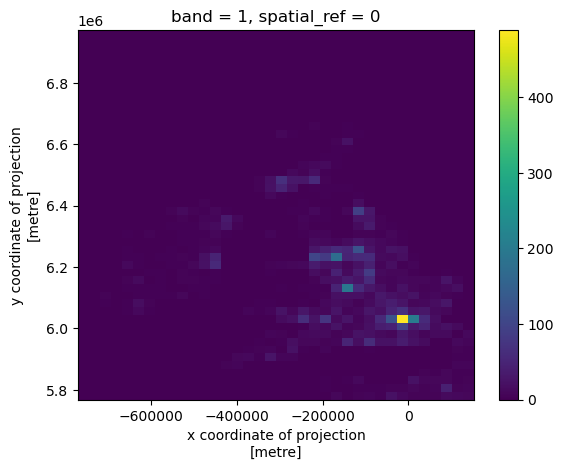

In [30]:
from rasterio.enums import Resampling
populations_coarse = populations.rio.reproject(populations.rio.crs, shape=tuple(int(i*0.01) for i in populations.shape), resampling=Resampling.average)
populations_coarse.plot()

In [31]:
populations.squeeze(drop=True).squeeze(drop=True)

<xarray.DataArray (y: 4814, x: 3698)> Size: 71MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 30kB -7.705e+05 -7.702e+05 ... 1.535e+05 1.538e+05
  * y            (y) float64 39kB 6.972e+06 6.971e+06 ... 5.769e+06 5.768e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

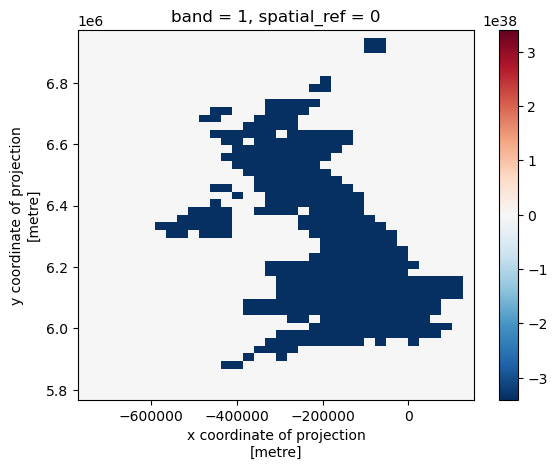

In [32]:
test = populations_coarse.rio.clip([spatial_units_national.to_crs(populations.rio.crs).loc["GBR"].geometry], invert=True)
test.plot()

In [4]:
electricity = pd.read_csv(path_electricity)

electricity = pd.merge(electricity, spatial_units_national[["country_code", "geometry"]], on="country_code")

electricity = gpd.GeoDataFrame(electricity, geometry="geometry").to_crs(populations.rio.crs)

<GeoAxes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

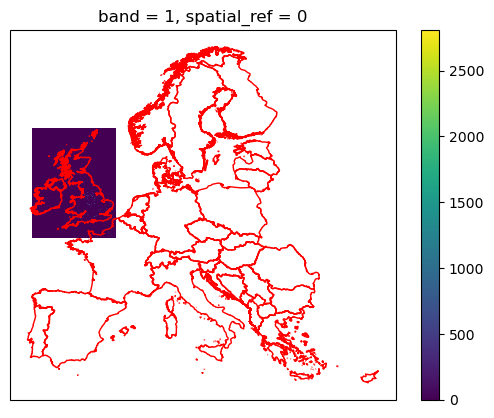

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
populations.plot.imshow(ax=ax)
spatial_units_national.to_crs(populations.rio.crs).plot(ax=ax, facecolor="none", edgecolor="red")

In [6]:
spatial_units_uk = spatial_units_national.loc[spatial_units_national["country_code"] == "GBR"]
spatial_units_uk

,country_code,name,type,proper,geometry
id,,,,,
GBR,GBR,United Kingdom,country,True,"MULTIPOLYGON (((-3.34384 58.64666, -3.29351 58..."


In [7]:
raster_data = populations_coarse
vector_data = spatial_units_uk.to_crs(raster_data.rio.crs)

assert raster_data.rio.crs == vector_data.crs, f"crs of raster data {raster_data.rio.crs} does not match crs of spatial units {vector_data.crs}"

geometry = vector_data.geometry.values[0]

mask = geometry_mask([geometry], out_shape=raster_data.shape, transform=raster_data.rio.transform(), invert=True)

mask = xr.DataArray(mask, coords=raster_data.coords, dims=raster_data.dims)
mask

<xarray.DataArray (y: 48, x: 36)> Size: 2kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * x            (x) float64 288B -7.578e+05 -7.321e+05 ... 1.154e+05 1.411e+05
  * y            (y) float64 384B 6.959e+06 6.934e+06 ... 5.806e+06 5.781e+06
    band         int64 8B 1
    spatial_ref  int64 8B 0

<xarray.DataArray (y: 48, x: 36)> Size: 2kB
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * x            (x) float64 288B -7.578e+05 -7.321e+05 ... 1.154e+05 1.411e+05
  * y            (y) float64 384B 6.959e+06 6.934e+06 ... 5.806e+06 5.781e+06
    band         int64 8B 1
    spatial_ref  int64 8B 0

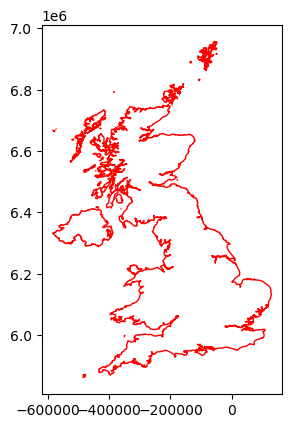

In [8]:
fig, ax = plt.subplots()
gpd.GeoDataFrame(data=None, geometry=[geometry]).plot(ax=ax, facecolor="none", edgecolor="red")
mask

In [136]:
def get_belongs_to_matrix(raster_data: xr.Dataset, spatial_units: gpd.GeoSeries) -> xr.Dataset:
    # create an empty dataarray with the shape of the raster data and the number of spatial units
    belongs_to_matrix = xr.DataArray(data=None, dims=["y", "x", "id"], coords={"y": raster_data.y, "x": raster_data.x, "id": spatial_units.index})
    belongs_to_matrix.attrs['transform'] = raster_data.rio.transform
    belongs_to_matrix.attrs['crs'] = raster_data.rio.crs

    for id, geometry in spatial_units.items():
        mask = geometry_mask([geometry], out_shape=raster_data.shape, transform=raster_data.rio.transform(), invert=True)
        mask = xr.DataArray(mask, coords=raster_data.coords, dims=raster_data.dims)
        belongs_to_matrix.loc[:,:,id] = mask

    # assert that belongs_to does not overlap
    belongs_to_matrix[:,:,0] = belongs_to_matrix.loc[:,:,"GBR"]
    overlapping = ((belongs_to_matrix != None).sum(axis=2) == 1).stack(coords=("x", "y"))
    overlapping = (belongs_to_matrix != None)

    # assert ((belongs_to_matrix != None).sum(axis=2) == 1).all(), f"belongs_to matrix has overlapping areas {0}"
    
    return belongs_to_matrix


belongs_to_matrix = get_belongs_to_matrix(
    raster_data = populations_coarse,
    spatial_units=spatial_units_national.geometry.to_crs(populations_coarse.rio.crs)
)

In [152]:
belongs_to_matrix.name = "belongs_to"
# df= belongs_to_matrix.to_dataframe().unstack("id")
# df.loc[df.values==True]

# Group by a dimension and count occurrences of True
stacked = belongs_to_matrix.stack(yx=["y", "x"])
counts = stacked.groupby('yx').sum(...)

# # Get the coordinates where True occurs more than once
true_coords_more_than_once = counts.where(counts > 1, drop=True).coords['yx']
true_coords_more_than_once

<xarray.DataArray 'yx' (yx: 377)> Size: 3kB
array([(6934170.086868489, -90059.8252213092),
       (6934170.086868489, -64379.269665753585),
       (6909097.170201823, -90059.8252213092), ...,
       (5906180.503535156, -295504.26966575364),
       (5881107.586868489, -423907.04744353145),
       (5881107.586868489, -398226.4918879759)], dtype=object)
Coordinates:
  * yx       (yx) object 3kB MultiIndex
  * y        (yx) float64 3kB 6.934e+06 6.934e+06 ... 5.881e+06 5.881e+06
  * x        (yx) float64 3kB -9.006e+04 -6.438e+04 ... -4.239e+05 -3.982e+05

In [131]:
# Create a sample DataArray
data = xr.DataArray([[True, False, True],
                     [True, True, False]],
                    dims=('x', 'y'))

# Group by a dimension and count occurrences of True

counts = data.groupby(('x', 'y')).sum(dim='country_code')

# Get the coordinates where True occurs more than once
true_coords_more_than_once = counts.where(counts > 1, drop=True).coords['x']
print(true_coords_more_than_once)


KeyError: 'x'

In [10]:
belongs_to_matrix.loc[:,:,"GBR"].squeeze().astype(int).plot()

NameError: name 'belongs_to_matrix' is not defined

<GeoAxes: title={'center': 'id = GBR'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

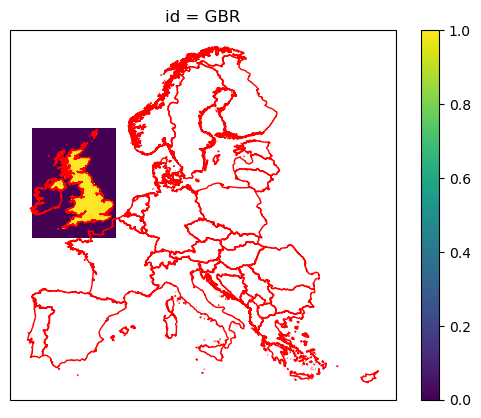

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
belongs_to_matrix.loc[:,:,"GBR"].squeeze().astype(int).plot(ax=ax)

spatial_units_national.to_crs(populations.rio.crs).plot(ax=ax, facecolor="none", edgecolor="red")

In [16]:
data = electricity
proxy = populations_coarse

belongs_to = get_belongs_to_matrix(proxy, spatial_units_national.geometry.to_crs(proxy.rio.crs))
_data = data.drop(columns=["geometry"]).set_index(["country_code", "year", "end_use", "cat_name"]).to_xarray()
belongs_to = belongs_to.rename({"id": "country_code"})  # TODO clean up

# # uniform proxy
normalization = belongs_to.sum(axis=(0, 1))

# raster proxy
normalization = (belongs_to * proxy).sum(axis=(0, 1))


# TODO Disaggregate data to raster using proxy
# raster_data_{x,y} = _data_{id} * belongs_to_{id,x,y} * normalization_{id} * proxy_{x,y}
raster_data = None

AssertionError: belongs_to matrix has overlapping areas <xarray.DataArray (y: 48, x: 36)> Size: 14kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=object)
Coordinates:
  * y        (y) float64 384B 6.959e+06 6.934e+06 ... 5.806e+06 5.781e+06
  * x        (x) float64 288B -7.578e+05 -7.321e+05 ... 1.154e+05 1.411e+05

In [ ]:
d = (belongs_to.astype(int) * _data).sel(year=2000, end_use="cooking_historically_electrified", cat_name="commercial", country_code="GBR") # normalization.coords
d.to_array().squeeze(drop=True).astype(float).plot()